## Setup

In [2]:
# boilerplate code
import os
from io import BytesIO
import numpy as np
import time
import PIL.Image
from IPython.display import clear_output, Image, display
from __future__ import print_function

import tensorflow as tf

model_fn = 'tensorflow_inception_graph.pb'

# creating TensorFlow session and loading the model
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

with tf.gfile.FastGFile(model_fn, 'rb') as f:
    # create an empty GraphDef object; this is the object we'll populate w/ data from the file
    graph_def = tf.GraphDef()
    # read binary data (different protocol for textual GraphDef objects); graph_def now contains
    # operations to be imported into the default graph
    graph_def.ParseFromString(f.read())
    
# define the input tensor
t_input = tf.placeholder(np.float32, name='input') 
# ?
imagenet_mean = 117.0
# subtract mean from all input data
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
# import graph_def into the Python Graph; second argument is dictionary mapping input names in
# graph_def to Tensor objects
tf.import_graph_def(graph_def, {'input':t_preprocessed})

## Helper Functions

In [3]:
def showarray(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 1)*255)
    # create an empty (?) file object
    f = BytesIO()
    # save array to file object
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("%s:0"%layer)

# Helper functions that use TF to resize an image
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)), session=kw.get('session'))
        return wrapper
    return wrap

def resize(img, size):
    img = tf.expand_dims(img, 0)
    return tf.image.resize_bilinear(img, size)[0,:,:,:]
resize = tffunc(np.float32, np.int32)(resize)

def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    sz = tile_size
    h, w = img.shape[:2]
    sx, sy = np.random.randint(sz, size=2)
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    grad = np.zeros_like(img)
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            sub = img_shift[y:y+sz,x:x+sz]
            g = sess.run(t_grad, {t_input:sub})
            grad[y:y+sz,x:x+sz] = g
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

## Deep Dream

In [4]:
def render_deepdream(t_obj, img0, disp=True,
                     iter_n=10, step=1.5, octave_n=4, octave_scale=1.4):
    t_score = tf.reduce_mean(t_obj) # defining the optimization objective
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # split the image into a number of octaves
    img = img0
    octaves = []
    if disp:
        print("Splitting image into octaves ...")
        
    for i in range(octave_n-1):
        hw = img.shape[:2]
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        hi = img-resize(lo, hw)
        img = lo
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            hi = octaves[-octave]
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            g = calc_grad_tiled(img, t_grad)
            img += g*(step / (np.abs(g).mean()+1e-7))
            if disp:
                print('.',end = ' ')

        if disp:
            clear_output()
            showarray(img/255.0)
        
    return img

## Full Example

In [ ]:
# import image
# img0 = PIL.Image.open('/home/mattw/Dropbox/deep-dream/clouds/mountain_clouds.JPG')
# img0 = np.float32(img0)

np.random.seed(0)
img0 = np.random.uniform(size=(512,512,3)) + 100.0
# showarray(img0/255.0)

# for exporting
dir_path = '/home/mattw/results/deep-dream/noise'

# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# loop over selected layers
# layer_nums = [1]
layer_nums = range(0, len(layers), 1)
layer_counter = 0
start = time.time()
for layer_num in layer_nums:

    # get string for saving
    layer_folder = 'layer_%03i' % layer_num
    folder_path = '/'.join([dir_path, layer_folder])
    if not os.path.isdir(folder_path):
        os.mkdir(folder_path)
    
    # use string to get layer output by name
    layer = layers[layer_num] 
    
    # loop over selected features
#     feature_nums = [3, 6, 9] 
    feature_nums = range(0, features[layer_num])
    
    # print updates
    layer_counter += 1
    print("Layer %i OF %i" % (layer_counter, len(layer_nums)))
    
    feature_counter = 0
    for feature_num in feature_nums:

        # print updates
        feature_counter += 1
        print("\rFeature %03i of %03i" % (feature_counter, len(feature_nums)), end="")
        
        # run deep dream; more iterations intensifies features, more octaves increases their size
        img = render_deepdream(T(layer)[:,:,:,feature_num], img0, iter_n=60, octave_n=4, disp=False)
        img = np.uint8(np.clip(img, 0, 255))
        
        # save output
        feature_name = "layer_%02i_feature_%03i.jpg" % (layer_num, feature_num)
        file_path = '/'.join([dir_path, layer_folder, feature_name])
        PIL.Image.fromarray(img).save(file_path, 'jpeg')
        
    print("\n")
    
end = time.time()
print("Total Elapsed Time: %i hours" % ((end-start)/3600))

Layer 1 OF 59
Feature 005 of 064

## Notes
### Snow
- sierra_in_snow (491x508): iter_n=20, octave_n=4

### Buildings
- open_road (655x437): iter_n=20, ocatve_n=4

### Trees
- osa_island (490x653): iter_n=20, octave_n=4

## Other Notes
### Spotty
- 08/022

### Puzzle Pieces
- 08/024
- 10/090
- 16/079
- 22/081

### Spindly/Spider Webs
- 08/006
- 10/000 (structural)
- 10/044
- 14/028
- 14/043
- 16/028
- 20/030
- 20/036
- 20/037
- 20/041
- 22/065
- 22/105
- 28/043
- 28/050
- 28/108

### Abstract Patterns
- many in layer 4
- 10/100
- 14/038
- 16/041
- 16/089
- 20/032
- 20/052
- 20/059
- 20/063
- 22/011
- 22/037
- 22/062
- 22/078
- 22/110
- 24/014
- 26/050
- 26/063
- 32/042
- 34/055
- 34/126
- 44/092

### Waves
- 16/011
- 16/013
- 16/061
- 16/065
- 16/074
- 16/080
- 16/081
- 24/016

### Trees/Grass
- 16/084
- 20/036
- 20/015
- 20/017
- 20/036
- 22/036
- 22/085
- 26/039
- 28/101
- 34/056

### Clouds
- 20/003

### Landscapes
- 20/031
- 22/020
- 26/017
- 28/039

### Cells/Bubbles
- 10/121
- 14/027
- 16/076
- 22/017
- 22/109
- 28/027
- 28/108
- 32/032
- 38/025
- 38/056
- 40/081
- 40/088
- 46/050
- 46/095
- 58/111

### Cylindrical Things
- 26/032
- 28/034
- 28/068
- 34/084
- 34/128
- 38/005
- 38/030
- 42/014
- 44/123
- 46/010
- 46/090
- 46/122

### Psy Waves
- 10/023
- 10/054
- 10/073
- 16/017
- 16/032
- 16/047
- 16/082
- 16/091
- 20/001
- 20/009 (fractally)
- 22/006 (folds)
- 22/042
- 26/006

### Glowing Cosmos
- 10/109
- 14/055
- 20/020
- 20/037
- 22/065
- 26/022
- 26/038
- 26/058
- 28/005
- 32/053
- 34/008
- 34/016
- 34/063
- 38/012
- 40/048
- 44/023
- 50/101 (underwater)
- 50/109 (underwater)
- 58/011
- 58/062

### Arches/Cathedrals/Pagodas
- 20/048
- 22/035
- 32/029
- 32/061
- 34/002
- 34/043
- 34/065
- 34/066
- 34/114
- 34/137
- 38/016

### Animal Patterning
- 28/073 (snake)
- 32/017 (feathers)
- 32/018 (feathers)
- 32/050
- 32/060 (coral)
- 34/016 (fish)
- 34/086 (snake)
- 34/088 (snake)
- 34/089 (scaley)
- 34/113 (feathers)
- 36/011 (feathers)
- 38/032
- 38/057
- 40/124
- 42/012
- 46/045
- 50/101
- 50/109
- 52/028
- 52/060
- 52/076 (coral)
- 52/188
- 58/012
- 58/018
- 58/043 (snake)
- 58/107 (snake)

### Pressed Liquid/Watercolors
- 22/025
- 22/066
- 26/048
- 32/026
- 32/062
- 34/041
- 34/090

### Other
- 38/013 (wolf?)
- 44/100 (vehicles)

### Possibly Interesting Objects
- waterfall
- fire/flame
- cracked glass
- rice paddies
- cliff face
- beaded water drops

In [100]:
for i, j in enumerate(features):
    print(i, j)

0 64
1 64
2 192
3 64
4 96
5 128
6 16
7 32
8 32
9 128
10 128
11 192
12 32
13 96
14 64
15 192
16 96
17 204
18 16
19 48
20 64
21 160
22 112
23 224
24 24
25 64
26 64
27 128
28 128
29 256
30 24
31 64
32 64
33 112
34 144
35 288
36 32
37 64
38 64
39 256
40 160
41 320
42 32
43 128
44 128
45 256
46 160
47 320
48 48
49 128
50 128
51 384
52 192
53 384
54 48
55 128
56 128
57 128
58 128


## Single Filter Example

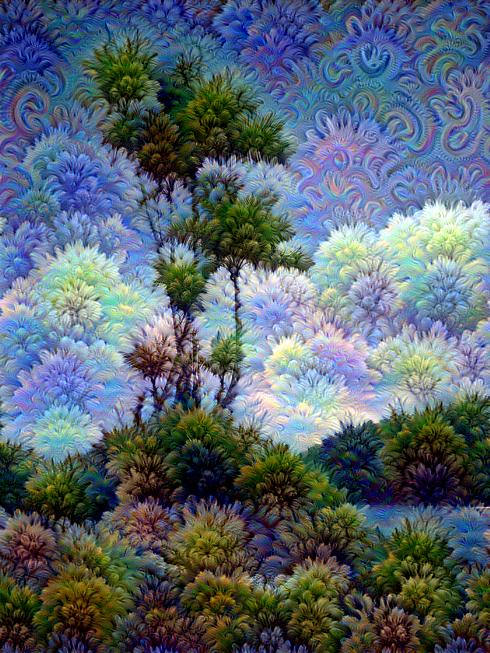

In [17]:
# get network info
layers = [op.name for op in graph.get_operations() if op.type=='Conv2D' and 'import/' in op.name]
features = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for name in layers]

# import image
# to downsample with ImageMagick: convert {source} -resize X% {output}
img0 = PIL.Image.open('/home/mattw/Dropbox/deep-dream/trees/osa_island.jpg')
# img0 = PIL.Image.open('/media/data/Dropbox/deep-dream/snow/sierra_in_snow.jpg')
# img0 = PIL.Image.open('/media/data/Dropbox/deep-dream/fireworks/P7041583.JPG')
img0 = np.float32(img0)
showarray(img0/255.0)

layer = layers[22]
feature_num = 101

# run deep dream; more iterations intensifies features, more octaves increases their size
img = render_deepdream(T(layer)[:,:,:,feature_num], img0, iter_n=60, octave_n=4)